![terrainbento logo](../images/terrainbento_logo.png)

# terrainbento model BasicRt steady-state solution

This model shows example usage of the BasicRt model from the TerrainBento package.

BasicRt modifies Basic by allowing for two lithologies:

$\frac{\partial \eta}{\partial t} = - K(\eta,\eta_C) Q^{1/2}S + D\nabla^2 \eta$

$K(\eta, \eta_C ) = w K_1 + (1 - w) K_2$

$w = \frac{1}{1+\exp \left( -\frac{(\eta -\eta_C )}{W_c}\right)}$

where $Q$ is the local stream discharge, $S$ is the local slope, $W_c$ is the contact-zone width, $K_1$ and $K_2$ are the erodabilities of the upper and lower lithologies, and $D$ is the regolith transport parameter. $w$ is a weight used to calculate the effective erodability $K(\eta, \eta_C)$ based on the depth to the contact zone and the width of the contact zone.

Refer to [Barnhart et al. (2019)](https://www.geosci-model-dev-discuss.net/gmd-2018-204/) for further explaination. For detailed information about creating a BasicRt model, see [the detailed documentation](https://terrainbento.readthedocs.io/en/latest/source/terrainbento.derived_models.model_basicRt.html).

This notebook (a) shows the initialization and running of this model, (b) saves a NetCDF file of the topography, which we will use to make an oblique Paraview image of the landscape, and (c) creates a slope-area plot at steady state.

In [1]:
# import required modules
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["font.size"] = 20
matplotlib.rcParams["pdf.fonttype"] = 42
%matplotlib inline

from landlab import imshow_grid, RasterModelGrid

from landlab.io.netcdf import write_netcdf
from landlab.values import random

from terrainbento import BasicRt, Clock, NotCoreNodeBaselevelHandler

np.random.seed(4897)

In [2]:
# in this example we will create a grid, a clock, a boundary handler,
# and an output writer. We will then use these to construct the model.

grid = RasterModelGrid((100, 160), 
                       xy_spacing=10)

z = random(grid, 
           "topographic__elevation",
           where="CORE_NODE")

contact = grid.add_zeros("node", "lithology_contact__elevation")
contact[grid.node_y > 500.0] = 10.
contact[grid.node_y <= 500.0] = -100000000.

clock = Clock(start=0,
              step=10, 
              stop=1e7)
ncnblh = NotCoreNodeBaselevelHandler(grid, 
                                     modify_core_nodes=True, 
                                     lowering_rate=-0.001)

In [3]:
# we can use an output writer to run until the model reaches steady state. 
class run_to_steady(object):
    def __init__(self, model):
        self.model = model
        self.last_z = self.model.z.copy()
        self.tolerance = 0.1
    def run_one_step(self):
        if model.model_time > 0:
            diff = (self.model.z[model.grid.core_nodes]
                    - self.last_z[model.grid.core_nodes])
            if max(abs(diff)) <= self.tolerance: 
                self.model.clock.stop = model._model_time
                print("Model reached steady state in " + str(model._model_time) + " time units\n")
            else:
                self.last_z = self.model.z.copy()
                if model._model_time <= self.model.clock.stop - self.model.output_interval:
                    self.model.clock.stop += self.model.output_interval

In [4]:
# initialize the model by passing the correct arguments and 
# keyword arguments. 

model = BasicRt(clock,
                grid, 
                boundary_handlers={"NotCoreNodeBaselevelHandler": ncnblh},
                output_interval=1e4, 
                save_first_timestep=True,
                output_prefix="output_netcdfs/basicRt.",
                fields=["topographic__elevation"],
                water_erodability_lower=0.001,
                water_erodability_upper=0.01, 
                m_sp=0.5,
                n_sp=1.0, 
                regolith_transport_parameter=0.1,  
                contact_zone__width=1.0,
                output_writers={"class": [run_to_steady]})

# to run the model as specified, execute the following line:
model.run()

Model reached steady state in 140000.0 time units



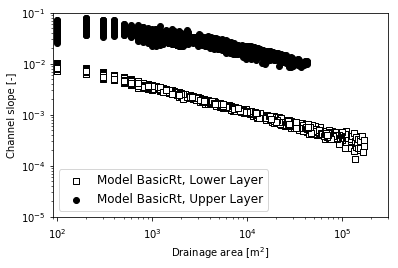

In [5]:
# MAKE SLOPE-AREA PLOT

# plot nodes that are not on the boundary or adjacent to it
core_not_boundary = np.array(model.grid.node_has_boundary_neighbor(model.grid.core_nodes)) == False
plotting_nodes = model.grid.core_nodes[core_not_boundary]

upper_plotting_nodes = plotting_nodes[model.grid.node_y[plotting_nodes] > 500.0]
                        
lower_plotting_nodes = plotting_nodes[model.grid.node_y[plotting_nodes] < 500.0]

# assign area_array and slope_array for ROCK
area_array_upper = model.grid.at_node["drainage_area"][upper_plotting_nodes]
slope_array_upper = model.grid.at_node["topographic__steepest_slope"][upper_plotting_nodes]
# assign area_array and slope_array for TILL
area_array_lower = model.grid.at_node["drainage_area"][lower_plotting_nodes]
slope_array_lower = model.grid.at_node["topographic__steepest_slope"][lower_plotting_nodes]

# instantiate figure and plot
fig = plt.figure(figsize=(6, 3.75))
slope_area = plt.subplot()

#plot the data for ROCK
slope_area.scatter(area_array_lower, slope_array_lower, marker="s", edgecolor="0", color="1", 
                   label = "Model BasicRt, Lower Layer")

#plot the data for TILL
slope_area.scatter(area_array_upper, slope_array_upper, color="k", 
                   label = "Model BasicRt, Upper Layer") 

#make axes log and set limits
slope_area.set_xscale("log")
slope_area.set_yscale("log")

slope_area.set_xlim(9*10**1, 3*10**5)
slope_area.set_ylim(1e-5, 1e-1)

#set x and y labels
slope_area.set_xlabel(r"Drainage area [m$^2$]")
slope_area.set_ylabel("Channel slope [-]")
slope_area.legend(scatterpoints=1,prop={"size":12})
slope_area.tick_params(axis="x", which="major", pad=7)

# save out an output figure
output_figure = os.path.join("output_figures/maintext_rock_till_slope_area.pdf")
fig.savefig(output_figure, bbox_inches="tight", dpi=1000) # save figure

In [6]:
# Save stack of all netcdfs for Paraview to use.
model.save_to_xarray_dataset(filename="output_netcdfs/basicRt.nc", 
                             time_unit="years", 
                             reference_time="model start", 
                             space_unit="meters")
        
# remove temporary netcdfs
model.remove_output_netcdfs()

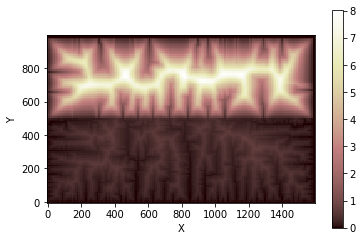

In [7]:
# make a plot of the final steady state topography
imshow_grid(model.grid, "topographic__elevation")

## Next Steps

- We recommend you review the [terrainbento manuscript](https://www.geosci-model-dev-discuss.net/gmd-2018-204/).

**The links to other notebooks will not work on GitHub. To use them you'll need to clone this repository and open the notebooks using [`jupyter notebook`](https://jupyter.org).**

- There are three additional introductory tutorials: 

    1) [Introduction terrainbento](http://localhost:8888/notebooks/example_usage/Introduction_to_terrainbento.ipynb) 
    
    2) [Introduction to boundary conditions in terrainbento](http://localhost:8888/notebooks/example_usage/introduction_to_boundary_conditions.ipynb)
    
    3) [Introduction to output writers in terrainbento](http://localhost:8888/notebooks/example_usage/introduction_to_output_writers.ipynb). 
    
    
- Five examples of steady state behavior in coupled process models can be found in the following notebooks:

    1) [Basic](http://localhost:8888/notebooks/coupled_process_elements/model_basic_steady_solution.ipynb) the simplest landscape evolution model in the terrainbento package.

    2) [BasicVm](http://localhost:8888/notebooks/coupled_process_elements/model_basic_var_m_steady_solution.ipynb) which permits the drainage area exponent to change

    3) [BasicCh](http://localhost:8888/notebooks/coupled_process_elements/model_basicCh_steady_solution.ipynb) which uses a non-linear hillslope erosion and transport law

    4) [BasicVs](http://localhost:8888/notebooks/coupled_process_elements/model_basicVs_steady_solution.ipynb) which uses variable source area hydrology

    5) **This Notebook**: [BasisRt](http://localhost:8888/notebooks/coupled_process_elements/model_basicRt_steady_solution.ipynb) which allows for two lithologies with different K values